## Install and link Google Drive to Notebook

In [ ]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls drive

## Install gym & gym[atari]

In [ ]:
!pip install gym
!pip install gym[atari]

## Import dependencies

In [4]:
from skimage import transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np    
import gym         

import pickle
from collections import deque

In [5]:
%matplotlib inline

In [7]:
env = gym.make('MsPacman-v0')

# One-hot encoding of actions
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

The size of our frame is:  Box(210, 160, 3)
The action size is :  9


In [0]:
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[0:-38,0:]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

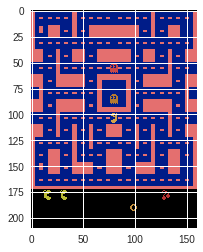

In [9]:
plt.imshow(env.reset())

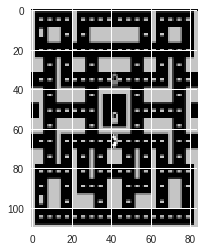

In [10]:
img = preprocess_frame(env.reset())
plt.imshow(img, cmap='gray')

In [0]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

In [0]:
### MODEL HYPERPARAMETERS
frames = 4  # Number of frames used for temporal difference, spatial inferences
state_size = [110, 84, frames]  
action_size = env.action_space.n 
learning_rate =  0.00025      # Alpha

### TRAINING HYPERPARAMETERS
total_episodes = 51            
max_steps = 500000             
batch_size = 64                

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001           # exponential decay rate for exploration prob

# Discounting rate
gamma = 0.9                    

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = frames                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

In [0]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
            

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [0]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

In [0]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [0]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    if i == 0:
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
    choice = np.random.randint(0,len(possible_actions))
    action = possible_actions[choice]
    next_state, reward, done, _ = env.step(np.argmax(action))
    
#     env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

In [0]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("drive/colab_data/tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

In [0]:
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = np.random.randint(0,len(possible_actions))
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

In [ ]:
saver = tf.train.Saver()

In [111]:
# Saver will help us to save our model
saver = tf.train.Saver()
rewards_list = []
if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())
#         saver.restore(sess, "drive/colab_data/model.ckpt")

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(np.argmax(action))
                
                if episode_render:
                    env.render()
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            if episode % 10 == 0:
                save_path = saver.save(sess, "drive/colab_data/model.ckpt")
                with open('drive/colab_data/reward_list.pkl', 'wb') as f:
                  pickle.dump(rewards_list, f)
                print("Model Saved")

Episode: 0 Total reward: 180.0 Explore P: 0.9364 Training Loss 1.5408
Model Saved
Episode: 1 Total reward: 310.0 Explore P: 0.8542 Training Loss 4.4692
Episode: 2 Total reward: 770.0 Explore P: 0.7584 Training Loss 1.5758
Episode: 3 Total reward: 310.0 Explore P: 0.7085 Training Loss 3.0277
Episode: 4 Total reward: 230.0 Explore P: 0.6648 Training Loss 3.0279
Episode: 5 Total reward: 320.0 Explore P: 0.6175 Training Loss 3.1724
Model Saved
Episode: 6 Total reward: 230.0 Explore P: 0.5836 Training Loss 5.8599
Episode: 7 Total reward: 240.0 Explore P: 0.5543 Training Loss 10.3835
Episode: 8 Total reward: 200.0 Explore P: 0.5248 Training Loss 4.4701
Episode: 9 Total reward: 150.0 Explore P: 0.5041 Training Loss 3.0282
Episode: 10 Total reward: 330.0 Explore P: 0.4733 Training Loss 1.6820
Model Saved
Episode: 11 Total reward: 200.0 Explore P: 0.4497 Training Loss 3.0573
Episode: 12 Total reward: 160.0 Explore P: 0.4293 Training Loss 3.0291
Episode: 13 Total reward: 320.0 Explore P: 0.4015 

In [0]:
writer.close()

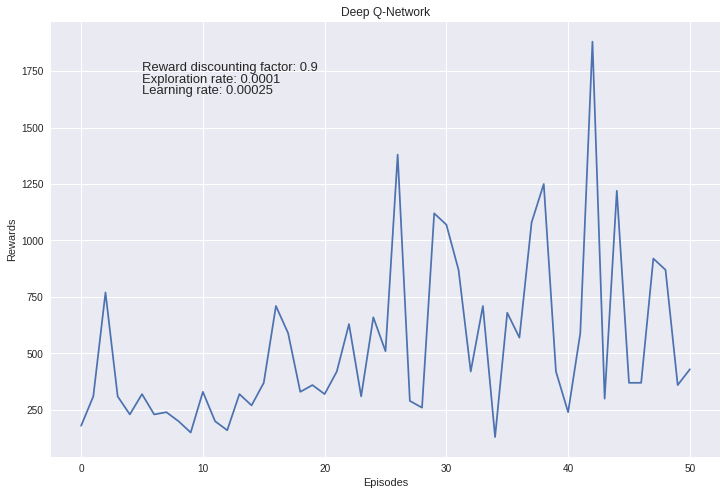

In [117]:
plt.figure(figsize=(12,8))
plt.plot([x[1] for x in rewards_list])
plt.title('Deep Q-Network')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.text(5, 1750, "Reward discounting factor: "+str(gamma), fontsize=13)
plt.text(5, 1700, "Exploration rate: "+str(decay_rate), fontsize=13)
plt.text(5, 1650, "Learning rate: "+str(learning_rate), fontsize=13)
plt.savefig(f'drive/colab_data/plot-decay-{decay_rate}.png')

In [ ]:
with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, "drive/colab_data/model.ckpt")
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(np.argmax(action))
            env.render()
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            
    env.close()

Source: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb